In [0]:
from io import BytesIO
import math
import random

import numpy as np
import PIL as pillow
from PIL.ImageOps import equalize
import requests
from IPython.display import display

In [0]:
def create_gif(frames):
  frames[0].save('the.gif', format='GIF', append_images=frames[1:], save_all=True, duration=1000, loop=0)

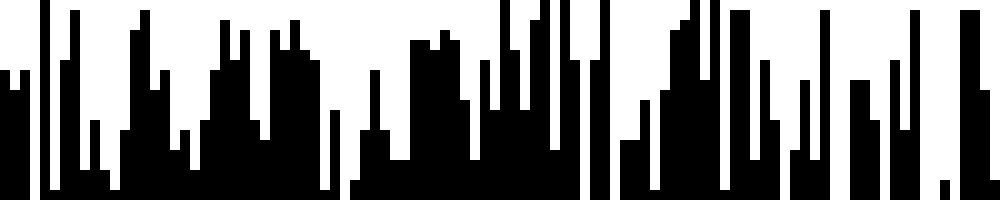

In [23]:
def load_image(link):
  response = requests.get(link)
  im = pillow.Image.open(BytesIO(response.content))
  return np.array(im)

def load_tiles(link, offsetx, offsety, spacex, spacey, tile_width, tile_height, count):
  image = load_image(link)
  image_height, image_width = image.shape[0], image.shape[1]
  tiles_per_row = (image_width - offsetx) // (tile_width + spacex)
  tiles = []
  for row in range(count // tiles_per_row + 1):
    for col in range(tiles_per_row):
      if row * tiles_per_row + col == count:
        return tiles
      tile = np.zeros((tile_height, tile_width, 4))
      for i in range(tile_height):
        for j in range(tile_width):
          tile[i][j] = image[offsety + (tile_height + spacey) * row + i][offsetx + (tile_width + spacex) * col + j]
      tiles.append(tile)
  return tiles

def entropy(prob):
  s = sum(prob)
  return -sum(0 if p == 0 else (p / s) * math.log(p / s) for p in prob)

def is_trivial(p):
  return entropy(p) == 0

def get_least_entropy(probs):
  res = []
  min_entropy = -1
  for i in range(len(probs)):
    for j in range(len(probs[i])):
      if is_trivial(probs[i][j]):
        continue
      entropy_ij = entropy(probs[i][j])
      if entropy_ij < min_entropy or min_entropy == -1:
        min_entropy = entropy(probs[i][j])
        res = [(i, j)]
      elif abs(entropy_ij - min_entropy) < 0.0000000001:
        res.append((i, j))
  return res

def get_distribution(a, b, c, d, hors, vers):
  TILES = len(a)
  res = [0 for _ in range(TILES)]
  s = sum(a) * sum(b) * sum(c) * sum(d)
  if s == 0:
    return res
  for k in range(TILES):
    for i1 in range(TILES):
      if (i1, k) not in vers:
        continue
      for i2 in range(TILES):
        if (i2, k) not in hors:
          continue
        for i3 in range(TILES):
          if (k, i3) not in hors:
            continue
          for i4 in range(TILES):
            if (k, i4) not in vers:
              continue
            res[k] += a[i1] * b[i2] * c[i3] * d[i4] / s
  return res

def show_probs(p):
  m = np.zeros((len(p), len(p[0])))
  TILES = len(p[0][0])
  for i in range(len(p)):
    for j in range(len(p[0])):
      s = sum(p[i][j])
      if s == 0:
        continue
      x = sum(k * p[i][j][k] / s for k in range(TILES))
      m[i][j] = x
  old_size = (150, 150)
  pil_im = pillow.Image.fromarray((m * 255).astype(np.uint8), "L").resize(old_size)
  new_size = (152, 152)
  bordered_im = pillow.Image.new("L", new_size)
  bordered_im.paste(pil_im, ((new_size[0]-old_size[0])//2, (new_size[1]-old_size[1])//2))
  display(bordered_im)
  return bordered_im

def update(i, j, tiles_count, probs, res, width, height, vers, hors):
  s = sum(probs[i][j])
  if s == 0:
    return probs, res
  res[i][j] = np.random.choice(list(range(tiles_count)), p=[x / s for x in probs[i][j]])
  probs[i][j] = [1 if k == res[i][j] else 0 for k in range(tiles_count)]
  unit_distr = [1 for _ in range(tiles_count)]
  #             pm20
  #       pm1m1 pm10 pm11
  # p0m2  p0m1  p00  p01  p02
  #       p1m1  p10  p11
  #             p20
  p0m2 = unit_distr[:] if j < 2 else probs[i][j - 2]
  pm1m1 = unit_distr[:] if i < 1 or j < 1 else probs[i - 1][j - 1]
  pm20 = unit_distr[:] if i < 2 else probs[i - 2][j]
  p1m1 = unit_distr[:] if i > height - 2 or j < 1 else probs[i + 1][j - 1]
  p00 = probs[i][j]
  pm11 = unit_distr[:] if i < 1 or j > width - 2 else probs[i - 1][j + 1]
  p20 = unit_distr[:] if i > height - 3 else probs[i + 2][j]
  p11 = unit_distr[:] if i > height - 2 or j > width - 2 else probs[i + 1][j + 1]
  p02 = unit_distr[:] if j > width - 3 else probs[i][j + 2]
  if i > 0 and not is_trivial(probs[i - 1][j]):
    probs[i - 1][j] = get_distribution(pm20, pm1m1, pm11, p00, hors, vers)
    if is_trivial(probs[i - 1][j]):
      probs, res = update(i - 1, j, tiles_count, probs, res, width, height, vers, hors)
  if j > 0 and not is_trivial(probs[i][j - 1]):
    probs[i][j - 1] = get_distribution(pm1m1, p0m2, p00, p1m1, hors, vers)
    if is_trivial(probs[i][j - 1]):
      probs, res = update(i, j - 1, tiles_count, probs, res, width, height, vers, hors)
  if j < width - 1 and not is_trivial(probs[i][j + 1]):
    probs[i][j + 1] = get_distribution(pm11, p00, p02, p11, hors, vers)
    if is_trivial(probs[i][j + 1]):
      probs, res = update(i, j + 1, tiles_count, probs, res, width, height, vers, hors)
  if i < height - 1 and not is_trivial(probs[i + 1][j]):
    probs[i + 1][j] = get_distribution(p00, p1m1, p11, p20, hors, vers)
    if is_trivial(probs[i + 1][j]):
      probs, res = update(i + 1, j, tiles_count, probs, res, width, height, vers, hors)
  return probs, res

def wave_collapse(tiles_count, width, height, hors, vers):
  unit_distr = np.ones(tiles_count) / tiles_count
  probs = [[unit_distr[:] for _ in range(width)] for _ in range(height)]
  res = [[-1 for _ in range(width)] for _ in range(height)]
  for _ in range(width * height):
    r = get_least_entropy(probs)
    if len(r) == 0:
      break
    i, j = random.choice(r)
    probs, res = update(i, j, tiles_count, probs, res, width, height, vers, hors)
  return res, probs

W, H = 100, 20
m, _ = wave_collapse(2, W, H, [(0, 0), (1, 1), (0, 1), (1, 0)], [(0, 0), (1, 1), (1, 0)])
pillow.Image.fromarray((np.array(m) * 255).astype(np.uint8), "L").resize((W * 10, H * 10))

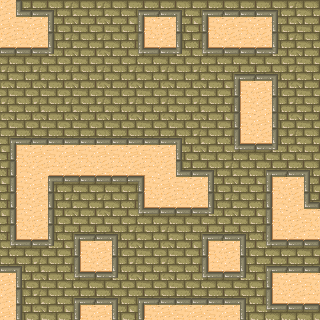

In [24]:
tiles = load_tiles("https://raw.githubusercontent.com/rprtr258/python-scripts/master/notebooks/wavecollapse/bricks.png", 1, 1, 1, 1, 32, 32, 13)

WIDTH, HEIGHT = 10, 10
m, p = wave_collapse(13, WIDTH, HEIGHT, [(2, 0), (7, 0), (12, 0), (2, 5), (7, 5), (12, 5), (2, 10), (7, 10), (12, 10), (0, 2), (5, 7), (10, 12), (0, 1), (1, 2), (5, 6), (6, 7), (10, 11), (11, 12), (3, 4), (8, 9), (5, 3), (6, 3), (3, 11), (3, 12), (10, 4), (11, 4), (4, 6), (4, 7), (5, 8), (6, 8), (8, 1), (8, 2), (0, 9), (1, 9), (9, 6), (9, 7), (4, 3), (9, 8), (4, 8), (9, 3), (1, 1), (6, 6), (11, 11)], [(0, 5), (1, 6), (2, 7), (5, 10), (6, 11), (7, 12), (3, 8), (4, 9), (3, 7), (3, 12), (1, 3), (6, 3), (4, 5), (4, 10), (1, 4), (6, 4), (8, 6), (8, 11), (2, 8), (7, 8), (9, 6), (9, 11), (0, 9), (5, 9), (8, 3), (9, 4), (8, 4), (9, 3), (5, 5), (6, 6), (7, 7), (0, 10), (1, 11), (2, 12), (10, 0), (10, 1), (10, 2), (11, 0), (11, 1), (11, 2), (12, 0), (12, 1), (12, 2)])

result_im = np.zeros((HEIGHT * 32, WIDTH * 32, 4))
TILES = len(tiles)
for i in range(HEIGHT):
  for j in range(WIDTH):
    for ii in range(32):
      for jj in range(32):
        s = sum(p[i][j])
        if s > 0:
          result_im[i * 32 + ii][j * 32 + jj] = sum(p[i][j][k] * tiles[k][ii][jj] for k in range(TILES))
        else:
          result_im[i * 32 + ii][j * 32 + jj] = sum(tiles[k][ii][jj] / len(tiles) for k in range(TILES))
pillow.Image.fromarray(result_im.astype(np.uint8), "RGBA")

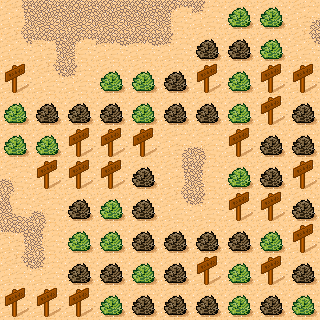

In [25]:
T = 16
tiles = load_tiles("https://raw.githubusercontent.com/rprtr258/python-scripts/master/notebooks/wavecollapse/earth.png", 1, 1, 1, 1, 32, 32, T)

WIDTH, HEIGHT = 10, 10
hors = [(2, 0), (7, 0), (12, 0), (2, 5), (7, 5), (12, 5), (2, 10), (7, 10), (12, 10), (0, 2), (5, 7), (10, 12), (0, 1), (1, 2), (5, 6), (6, 7), (10, 11), (11, 12), (3, 4), (8, 9), (5, 3), (6, 3), (3, 11), (3, 12), (10, 4), (11, 4), (4, 6), (4, 7), (5, 8), (6, 8), (8, 1), (8, 2), (0, 9), (1, 9), (9, 6), (9, 7), (4, 3), (9, 8), (4, 8), (9, 3), (1, 1), (6, 6), (11, 11)]
vers = [(0, 5), (1, 6), (2, 7), (5, 10), (6, 11), (7, 12), (3, 8), (4, 9), (3, 7), (3, 12), (1, 3), (6, 3), (4, 5), (4, 10), (1, 4), (6, 4), (8, 6), (8, 11), (2, 8), (7, 8), (9, 6), (9, 11), (0, 9), (5, 9), (8, 3), (9, 4), (8, 4), (9, 3), (5, 5), (6, 6), (7, 7), (0, 10), (1, 11), (2, 12), (10, 0), (10, 1), (10, 2), (11, 0), (11, 1), (11, 2), (12, 0), (12, 1), (12, 2)]
for b in range(13, T):
  hors += [(2, b), (7, b), (12, b)]
  hors += [(b, 0), (b, 5), (b, 10)]
  vers += [(10, b), (11, b), (12, b)]
  vers += [(b, 0), (b, 1), (b, 2)]
  for a in range(13, T):
    hors.append((a, b))
    vers.append((a, b))
m, p = wave_collapse(22, WIDTH, HEIGHT, hors, vers)

result_im = np.zeros((HEIGHT * 32, WIDTH * 32, 4))
TILES = len(tiles)
for i in range(HEIGHT):
  for j in range(WIDTH):
    for ii in range(32):
      for jj in range(32):
        s = sum(p[i][j])
        if s > 0:
          result_im[i * 32 + ii][j * 32 + jj] = sum(p[i][j][k] * tiles[k][ii][jj] for k in range(TILES))
        else:
          result_im[i * 32 + ii][j * 32 + jj] = sum(tiles[k][ii][jj] / len(tiles) for k in range(TILES))
pillow.Image.fromarray(result_im.astype(np.uint8), "RGBA")